# Setting up the environment

First, we set up our environment. We use an already compiled and packaged installation of HOOMD-blue and the hoomd-dlext plugin.
We download it from Google Drive and make it visible to the running python process in this Colab instance.

In [1]:
%%bash

BASE_URL="https://drive.usercontent.google.com/download?id=1hsKkKtdxZTVfHKgqVF6qV2e-4SShmhr7"
COOKIES="/tmp/cookies.txt"
CONFIRMATION="$(wget -q --save-cookies $COOKIES --keep-session-cookies --no-check-certificate $BASE_URL -O- | sed -rn 's/.*confirm=(\w+).*/\1\n/p')"

wget -q --load-cookies $COOKIES "$BASE_URL&confirm=$CONFIRMATION" -O pysages-env.zip
rm -rf $COOKIES

In [2]:
%env PYSAGES_ENV=/env/pysages

env: PYSAGES_ENV=/env/pysages


In [3]:
%%bash

mkdir -p $PYSAGES_ENV .
unzip -qquo pysages-env.zip -d $PYSAGES_ENV

In [5]:
import os
import sys

ver = sys.version_info
sys.path.append(os.environ["PYSAGES_ENV"] + "/lib/python" + str(ver.major) + "." + str(ver.minor) + "/site-packages/")

os.environ["LD_LIBRARY_PATH"] = "/usr/lib/x86_64-linux-gnu:" + os.environ["LD_LIBRARY_PATH"]

We'll also need some additional python dependencies

In [6]:
!pip install -qq "numpy<2" gsd > /dev/null

## PySAGES

The next step is to install PySAGES. We retrieve the latest version from GitHub and add its dependecies via `pip`.

In [7]:
!pip install -qq git+https://github.com/SSAGESLabs/PySAGES.git > /dev/null

# SpectralABF-biased simulations

In [ ]:
%%bash

mkdir /content/spectral-abf
cd /content/spectral-abf

SpectralABF gradually learns a better approximation to the coefficients of a basis functions expansion of the free energy of a system, from the generalized mean forces in a similar fashion to the ABF sampling method.

For this Colab, we are using butane as the example molecule.

In [1]:
import hoomd
import gsd.hoomd
import numpy as np


pi = np.pi
kT = 0.596161
dt = 0.02045


def generate_simulation(kT = kT, dt = dt, device = hoomd.device.auto_select(), seed = 42):
    """
    Generates a simulation context to which will attatch our sampling method.
    """
    simulation = hoomd.Simulation(device=device, seed=seed)

    snapshot = gsd.hoomd.Frame()

    snapshot.configuration.box = [41, 41, 41, 0, 0, 0]

    snapshot.particles.N = N = 14
    snapshot.particles.types = ["C", "H"]
    snapshot.particles.typeid = np.zeros(N, dtype=int)
    snapshot.particles.position = np.zeros((N, 3))
    snapshot.particles.mass = np.zeros(N, dtype=float)
    snapshot.particles.charge = np.zeros(N, dtype=float)
    snapshot.particles.typeid[0] = 0
    snapshot.particles.typeid[1:4] = 1
    snapshot.particles.typeid[4] = 0
    snapshot.particles.typeid[5:7] = 1
    snapshot.particles.typeid[7] = 0
    snapshot.particles.typeid[8:10] = 1
    snapshot.particles.typeid[10] = 0
    snapshot.particles.typeid[11:14] = 1

    positions = np.array(
        [
            [-2.990196, 0.097881, 0.000091],
            [-2.634894, -0.911406, 0.001002],
            [-2.632173, 0.601251, -0.873601],
            [-4.060195, 0.099327, -0.000736],
            [-2.476854, 0.823942, 1.257436],
            [-2.832157, 1.833228, 1.256526],
            [-2.834877, 0.320572, 2.131128],
            [-0.936856, 0.821861, 1.258628],
            [-0.578833, 1.325231, 0.384935],
            [-0.581553, -0.187426, 1.259538],
            [-0.423514, 1.547922, 2.515972],
            [-0.781537, 1.044552, 3.389664],
            [0.646485, 1.546476, 2.516800],
            [-0.778816, 2.557208, 2.515062],
        ]
    )

    reference_box_low_coords = np.array([-22.206855, -19.677099, -19.241968])
    box_low_coords = np.array([-41.0 / 2, -41.0 / 2, -41.0 / 2])
    positions += box_low_coords - reference_box_low_coords

    snapshot.particles.position[:] = positions[:]

    mC = 12.00
    mH = 1.008

    # fmt: off
    snapshot.particles.mass[:] = [
        mC, mH, mH, mH,  # grouped by carbon atoms
        mC, mH, mH,
        mC, mH, mH,
        mC, mH, mH, mH,
    ]

    reference_charges = np.array(
        [
            -0.180000, 0.060000, 0.060000, 0.060000,  # grouped by carbon atoms
            -0.120000, 0.060000, 0.060000,
            -0.120000, 0.060000, 0.060000,
            -0.180000, 0.060000, 0.060000, 0.060000,
        ]
    )
    # fmt: on

    charge_conversion = 18.22262
    snapshot.particles.charge[:] = charge_conversion * reference_charges[:]

    snapshot.particles.validate()

    snapshot.bonds.N = 13
    snapshot.bonds.types = ["CC", "CH"]
    snapshot.bonds.typeid = np.zeros(13, dtype=int)
    snapshot.bonds.typeid[0:3] = 1
    snapshot.bonds.typeid[3] = 0
    snapshot.bonds.typeid[4:6] = 1
    snapshot.bonds.typeid[6] = 0
    snapshot.bonds.typeid[7:9] = 1
    snapshot.bonds.typeid[9] = 0
    snapshot.bonds.typeid[10:13] = 1

    snapshot.bonds.group = np.zeros((13, 2), dtype=int)
    # fmt: off
    snapshot.bonds.group[:] = [
        [0, 2], [0, 1], [0, 3], [0, 4],  # grouped by carbon atoms
        [4, 5], [4, 6], [4, 7],
        [7, 8], [7, 9], [7, 10],
        [10, 11], [10, 12], [10, 13],
    ]
    # fmt: on

    snapshot.angles.N = 24
    snapshot.angles.types = ["CCC", "CCH", "HCH"]
    snapshot.angles.typeid = np.zeros(24, dtype=int)
    snapshot.angles.typeid[0:2] = 2
    snapshot.angles.typeid[2] = 1
    snapshot.angles.typeid[3] = 2
    snapshot.angles.typeid[4:8] = 1
    snapshot.angles.typeid[8] = 0
    snapshot.angles.typeid[9] = 2
    snapshot.angles.typeid[10:14] = 1
    snapshot.angles.typeid[14] = 0
    snapshot.angles.typeid[15] = 2
    snapshot.angles.typeid[16:21] = 1
    snapshot.angles.typeid[21:24] = 2

    snapshot.angles.group = np.zeros((24, 3), dtype=int)
    # fmt: off
    snapshot.angles.group[:] = [
        [1, 0, 2], [2, 0, 3], [2, 0, 4],  # grouped by carbon atoms
        [1, 0, 3], [1, 0, 4], [3, 0, 4],
        # ---
        [0, 4, 5], [0, 4, 6], [0, 4, 7],
        [5, 4, 6], [5, 4, 7], [6, 4, 7],
        # ---
        [4, 7, 8], [4, 7, 9], [4, 7, 10],
        [8, 7, 9], [8, 7, 10], [9, 7, 10],
        # ---
        [7, 10, 11], [7, 10, 12], [7, 10, 13],
        [11, 10, 12], [11, 10, 13], [12, 10, 13],
    ]
    # fmt: on

    snapshot.dihedrals.N = 27
    snapshot.dihedrals.types = ["CCCC", "HCCC", "HCCH"]
    snapshot.dihedrals.typeid = np.zeros(27, dtype=int)
    snapshot.dihedrals.typeid[0:2] = 2
    snapshot.dihedrals.typeid[2] = 1
    snapshot.dihedrals.typeid[3:5] = 2
    snapshot.dihedrals.typeid[5] = 1
    snapshot.dihedrals.typeid[6:8] = 2
    snapshot.dihedrals.typeid[8:11] = 1
    snapshot.dihedrals.typeid[11] = 0
    snapshot.dihedrals.typeid[12:14] = 2
    snapshot.dihedrals.typeid[14] = 1
    snapshot.dihedrals.typeid[15:17] = 2
    snapshot.dihedrals.typeid[17:21] = 1
    snapshot.dihedrals.typeid[21:27] = 2

    snapshot.dihedrals.group = np.zeros((27, 4), dtype=int)
    # fmt: off
    snapshot.dihedrals.group[:] = [
        [2, 0, 4, 5], [2, 0, 4, 6], [2, 0, 4, 7],  # grouped by pairs of central atoms
        [1, 0, 4, 5], [1, 0, 4, 6], [1, 0, 4, 7],
        [3, 0, 4, 5], [3, 0, 4, 6], [3, 0, 4, 7],
        # ---
        [0, 4, 7, 8], [0, 4, 7, 9], [0, 4, 7, 10],
        [5, 4, 7, 8], [5, 4, 7, 9], [5, 4, 7, 10],
        [6, 4, 7, 8], [6, 4, 7, 9], [6, 4, 7, 10],
        # ---
        [4, 7, 10, 11], [4, 7, 10, 12], [4, 7, 10, 13],
        [8, 7, 10, 11], [8, 7, 10, 12], [8, 7, 10, 13],
        [9, 7, 10, 11], [9, 7, 10, 12], [9, 7, 10, 13],
    ]
    # fmt: on

    snapshot.pairs.N = 27
    snapshot.pairs.types = ["CCCC", "HCCC", "HCCH"]
    snapshot.pairs.typeid = np.zeros(27, dtype=int)
    snapshot.pairs.typeid[0:1] = 0
    snapshot.pairs.typeid[1:11] = 1
    snapshot.pairs.typeid[11:27] = 2
    snapshot.pairs.group = np.zeros((27, 2), dtype=int)
    # fmt: off
    snapshot.pairs.group[:] = [
        # CCCC
        [0, 10],
        # HCCC
        [0, 8],
        [0, 9],
        [5, 10], [6, 10],
        [1, 7], [2, 7], [3, 7],
        [11, 4], [12, 4], [13, 4],
        # HCCH
        [1, 5], [1, 6],
        [2, 5], [2, 6],
        [3, 5], [3, 6],
        [5, 8], [6, 8],
        [5, 9], [6, 9],
        [8, 11], [8, 12], [8, 13],
        [9, 11], [9, 12], [9, 13],
    ]
    # fmt: on

    simulation.create_state_from_snapshot(snapshot, domain_decomposition=(None, None, None))
    simulation.run(0)

    exclusions = ["bond", "1-3", "1-4"]
    nl = hoomd.md.nlist.Cell(buffer=0.4, exclusions=exclusions)
    lj = hoomd.md.pair.LJ(nlist=nl, default_r_cut=12.0)
    lj.params[("C", "C")] = dict(epsilon=0.07, sigma=3.55)
    lj.params[("H", "H")] = dict(epsilon=0.03, sigma=2.42)
    lj.params[("C", "H")] = dict(epsilon=np.sqrt(0.07 * 0.03), sigma=np.sqrt(3.55 * 2.42))

    coulomb = hoomd.md.long_range.pppm.make_pppm_coulomb_forces(
        nlist=nl, resolution=[64, 64, 64], order=6, r_cut=12.0
    )

    harmonic = hoomd.md.bond.Harmonic()
    harmonic.params["CC"] = dict(k=2 * 268.0, r0=1.529)
    harmonic.params["CH"] = dict(k=2 * 340.0, r0=1.09)

    angle = hoomd.md.angle.Harmonic()
    angle.params["CCC"] = dict(k=2 * 58.35, t0=112.7 * pi / 180)
    angle.params["CCH"] = dict(k=2 * 37.5, t0=110.7 * pi / 180)
    angle.params["HCH"] = dict(k=2 * 33.0, t0=107.8 * pi / 180)

    dihedral = hoomd.md.dihedral.OPLS()
    dihedral.params["CCCC"] = dict(k1=1.3, k2=-0.05, k3=0.2, k4=0.0)
    dihedral.params["HCCC"] = dict(k1=0.0, k2=0.0, k3=0.3, k4=0.0)
    dihedral.params["HCCH"] = dict(k1=0.0, k2=0.0, k3=0.3, k4=0.0)

    lj_special_pairs = hoomd.md.special_pair.LJ()
    lj_special_pairs.params["CCCC"] = dict(epsilon=0.07, sigma=3.55)
    lj_special_pairs.params["HCCH"] = dict(epsilon=0.03, sigma=2.42)
    lj_special_pairs.params["HCCC"] = dict(epsilon=np.sqrt(0.07 * 0.03), sigma=np.sqrt(3.55 * 2.42))
    lj_special_pairs.r_cut["CCCC"] = 12.0
    lj_special_pairs.r_cut["HCCC"] = 12.0
    lj_special_pairs.r_cut["HCCH"] = 12.0
    coulomb_special_pairs = hoomd.md.special_pair.Coulomb()
    coulomb_special_pairs.params["CCCC"] = dict(alpha=0.5)
    coulomb_special_pairs.params["HCCC"] = dict(alpha=0.5)
    coulomb_special_pairs.params["HCCH"] = dict(alpha=0.5)
    coulomb_special_pairs.r_cut["HCCH"] = 12.0
    coulomb_special_pairs.r_cut["CCCC"] = 12.0
    coulomb_special_pairs.r_cut["HCCC"] = 12.0

    nvt = hoomd.md.methods.Langevin(filter=hoomd.filter.All(), kT=kT)

    integrator = hoomd.md.Integrator(dt=dt)
    integrator.forces.append(lj)
    integrator.forces.append(coulomb[0])
    integrator.forces.append(coulomb[1])
    integrator.forces.append(harmonic)
    integrator.forces.append(angle)
    integrator.forces.append(dihedral)
    integrator.forces.append(lj_special_pairs)
    integrator.forces.append(coulomb_special_pairs)
    integrator.methods.append(nvt)
    simulation.operations.integrator = integrator

    return simulation

Next, we load PySAGES and the relevant classes and methods for our problem

In [2]:
from pysages.grids import Grid
from pysages.colvars import DihedralAngle
from pysages.methods import SpectralABF

import pysages

The next step is to define the collective variable (CV). In this case, we choose the central dihedral angle.

We define a grid, which will be used to indicate how we want to bin the forces that will be used to approximate the biasing potential and its gradient.

In [3]:
cvs = [DihedralAngle([0, 4, 7, 10])]
grid = Grid(lower=(-pi,), upper=(pi,), shape=(64,), periodic=True)
timesteps = int(5e5)

method = SpectralABF(cvs, grid)

We now simulate $5\times10^5$ time steps.
Make sure to run with GPU support, otherwise, it can take a very long time.

In [4]:
run_result = pysages.run(method, generate_simulation, timesteps)

HOOMD-blue v2.9.7 CUDA (11.2) DOUBLE HPMC_MIXED MPI SSE SSE2 
Compiled: 23/06/22
Copyright (c) 2009-2019 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, J Glaser, and S C Glotzer. "HOOMD-blue: A Python package for
  high-performance molecular dynamics and hard particle Monte Carlo
  simulations", Computational Materials Science 173 (2020) 109363
-----
HOOMD-blue is running on the following GPU(s):
 [0]       Quadro RTX 4000  36 SM_7.5 @ 1.54 GHz, 7959 MiB DRAM, MNG
notice(2): Group "all" created containing 14 particles
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 7 exclusions             : 6
notice(2): Particles with 10 exclusions             : 6
notice(2): Particles with 13 exclusions             : 2
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
notice(2): Group "charged" created containing 14 particles
-----
You are 

Time 00:00:11 | Step 8226 / 500000 | TPS 822.534 | ETA 00:09:57
Time 00:00:21 | Step 17784 / 500000 | TPS 955.763 | ETA 00:08:24
Time 00:00:31 | Step 27072 / 500000 | TPS 928.766 | ETA 00:08:29
Time 00:00:41 | Step 36019 / 500000 | TPS 894.616 | ETA 00:08:38
Time 00:00:51 | Step 45469 / 500000 | TPS 944.906 | ETA 00:08:01
Time 00:01:01 | Step 54809 / 500000 | TPS 933.948 | ETA 00:07:56
Time 00:01:11 | Step 64099 / 500000 | TPS 928.939 | ETA 00:07:49
Time 00:01:21 | Step 73477 / 500000 | TPS 937.792 | ETA 00:07:34
Time 00:01:31 | Step 82917 / 500000 | TPS 943.977 | ETA 00:07:21
Time 00:01:41 | Step 92421 / 500000 | TPS 950.371 | ETA 00:07:08
Time 00:01:51 | Step 101874 / 500000 | TPS 945.263 | ETA 00:07:01
Time 00:02:01 | Step 111302 / 500000 | TPS 942.79 | ETA 00:06:52
Time 00:02:11 | Step 120690 / 500000 | TPS 938.793 | ETA 00:06:44
Time 00:02:21 | Step 129661 / 500000 | TPS 897.03 | ETA 00:06:52
Time 00:02:31 | Step 138423 / 500000 | TPS 876.136 | ETA 00:06:52
Time 00:02:41 | Step 14


## Analysis
PySAGES provides an `analyze` method that makes it easier to get the free energy of different simulation runs.

In [5]:
result = pysages.analyze(run_result)

Let's plot now the free energy!

In [6]:
import matplotlib.pyplot as plt

In [7]:
mesh = result["mesh"]
A = result["free_energy"]
# Alternatively:
# fes_fn = result["fes_fn"]
# A = fes_fn(mesh)

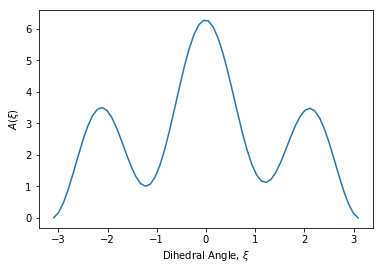

In [8]:
fig, ax = plt.subplots()

ax.set_xlabel(r"Dihedral Angle, $\xi$")
ax.set_ylabel(r"$A(\xi)$")
ax.plot(mesh, A)

fig.show()